In [5]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [3]:
def f(x):
    return 3*x**2 - 4*x + 5

In [4]:
f(3.0)

20.0

In [5]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

: 

: 

In [ ]:
#getting more complex
h = 0.0001
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
print(d1)

4.0


In [ ]:
h = 0.0001

#inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c +=h
d2 = a*b + c
print('d1', d1)
print('d2', d2)
print('slope', (d2-d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


In [3]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self._backward = lambda: None
        self.label = label
        self.grad = 0.0
        
    def __repr__(self):
        return f"Value(date={self.data}, label={self.label})"
    
    def __neg__(self):
        return self * -1
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad 
        out._backward = _backward
        return out
    
    def __radd__(self, other):
        return self + other
    
    def __sub__(self, other):
        return self + (-other)

    def __rsub__(self, other):
        return other + (-self)
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        return self*other
    
    def __truediv__(self, other):
        return self*other**-1
    
    def __rtruediv__(self, other):
        other = Value(other)
        return other/self
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), 'only supporting int/float for now'
        out = Value(self.data**other, (self, ), f'**{other}')
        def _backward():
            self.grad += other*self.data**(other - 1)*out.grad 
        out._backward = _backward
        return out
    
    def tanh(self):
        n = self.data
        if 2*n > 700 or 2*n < -700 :
            print('overflow', n)
        out = Value((math.exp(2*n) - 1) / (math.exp(2*n) + 1), (self, ), 'tanh')
        def _backward():
            self.grad += (1 - out.data**2)*out.grad
        out._backward = _backward
        return out
    
    def exp(self):
        n = self.data
        out = Value(math.exp(n), (self, ) ,'exp')
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
    
    def backward(self):
        topos = []
        visited_nodes = set()
        def build_topo(v):
            if v not in visited_nodes : 
                visited_nodes.add(v)
                for child in v._prev : 
                    build_topo(child)
                topos.append(v)
        self.grad = 1.0
        build_topo(self)
        for node in reversed(topos) :
            node._backward()

        

In [ ]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot

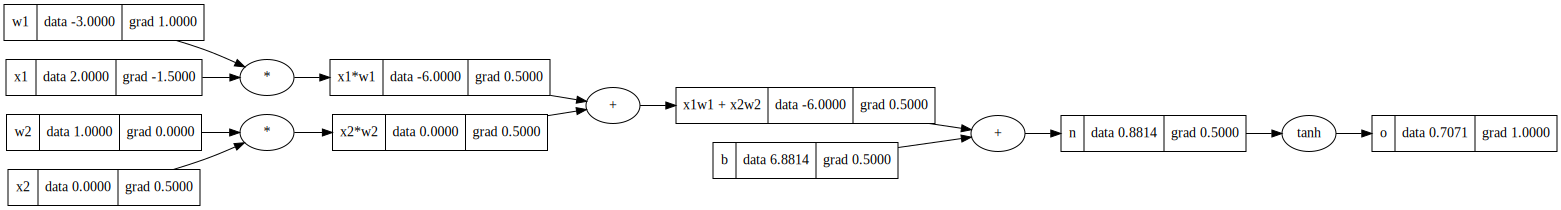

In [ ]:
# inputs x1 and x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1 and w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neutron
b = Value(6.8813735870195432, label='b')
#x1*w1 + x2*w2 + b 
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label ='n'
o = n.tanh(); o.label='o'
o.backward()
draw_dot(o)


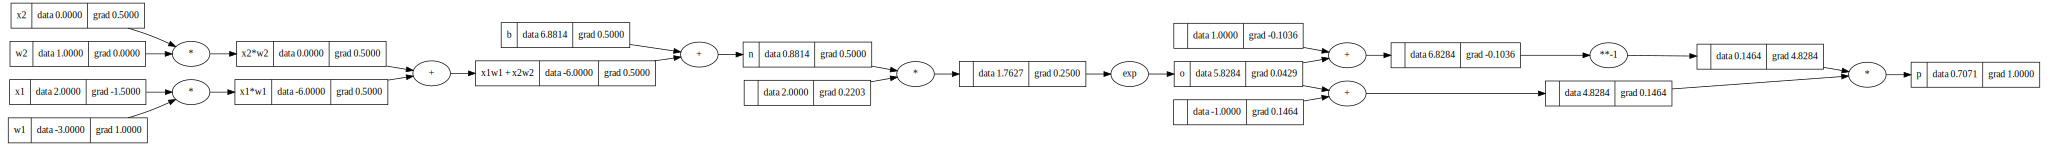

In [ ]:
# inputs x1 and x2
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')
# weights w1 and w2
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')
# bias of the neutron
b = Value(6.8813735870195432, label = 'b')
#x1*w1 + x2*w2 + b 
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = (2*n).exp(); o.label = 'o'
p = (o - 1) / (o + 1); p.label = 'p'
p.backward()
draw_dot(p)

In [ ]:
import torch

In [ ]:
x1 = torch.tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.tensor([1.0]).double(); w2.requires_grad = True
b = torch.tensor([6.8813735870195432]).double(); b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)
print(round(o.data.item(), 4))
o.backward()

print('---')
print('x1', round(x1.grad.item(), 4))
print('x2', round(x2.grad.item(), 4))
print('w1', round(w1.grad.item(), 4))
print('w2', round(w2.grad.item(), 4))

0.7071
---
x1 -1.5
x2 0.5
w1 1.0
w2 0.0


In [1]:
class Neuron:
    def __init__(self, nin):
        # nin : number of input of the neuron
        self.w = [Value(random.uniform(-1, 1), label ='w') for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1), label ='b')
    def __call__(self, x):
        # w*x + b
        if type(x) != list:
            raise TypeError('Input must be a list')
        if len(x) != len(self.w):
            raise ValueError('Input dimension does not match')
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b) 
        out = act.tanh()
        return out
    def parameters(self):
        return self.w + [self.b]
    
    def __repr__(self):
        return f"Neuron with {len(self.w)} inputs"
    
class Layer:
    # nin : number of input for each neuron in this layer, since the network is fully connected, nin = number of neuron in previous layer
    # nout : number of output or how many neuron in this layer
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs if len(outs) > 1 else outs[0]
    
    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]
    
    def __repr__(self):
        return f"Layer with [{', '.join(str(Neuron) for Neuron in self.neurons)}]"
    
class MLP:
    # nin : number of input for each node in the first layer of the network
    # nouts : array of number of output for each layer
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(sz)-1)]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    
    def __repr__(self):
        return f"MLP with [{', '.join(str(Layer) for Layer in self.layers)}]"


In [6]:
n = MLP(3, [4, 4 , 1])

In [7]:
# we want the neural network to output 1.0 when given [2.0, 3.0, -1.0], etc.
xs = [[2.0, 3.0, -1.0], [3.0, -1.0, 0.5], [0.5, 1.0, 1.0], [1.0, 1.0, -1.0]] # training inputs
ys = [1.0, -1, 0, 1.0] # desired targets

In [10]:
stepSize = 200
for step in range(stepSize):
    step += 1
    # forward pass
    y_pred = [n(x) for x in xs]
    loss = sum([(yout - ygt)**2 for yout, ygt in zip(y_pred, ys)])
    # backward pass
    loss.backward()
    # update
    for p in n.parameters():
        p.data += -p.grad * 0.05
        p.grad = 0.0
print('Final loss:', loss.data)
y_pred


Final loss: 0.00934762953223708


[Value(date=0.9784982926427066, label=),
 Value(date=-0.9549771391216606, label=),
 Value(date=0.07971309778923896, label=),
 Value(date=0.977548493321576, label=)]